In [1]:
import mediapipe as mp
from mediapipe.tasks.python import vision
import cv2 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
from multiprocessing.pool import ThreadPool as Pool
from gc import collect
from mediapipe.python.solutions.drawing_utils import DrawingSpec

from matplotlib import pyplot as plt

# OLD VERSION

In [2]:
!ls

LSFB-tries				    github_token.txt
Mediapipe_test.ipynb			    graphs
README.md				    mediapipe_models
arcface.py				    mediapipe_swin_arcface.ipynb
asl-sign-detection-pytorch-lightning.ipynb  models
autsl-custom-try.ipynb			    pizdec.ipynb
data					    prof_logs
ds.py					    requirements.txt
ds_preprocess.ipynb			    swin_arcface.ipynb
gestures				    wandb


In [35]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)
    timestamps = []
    cur_timestamp = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        timestamps.append(cur_timestamp)
        cur_timestamp += int(1.0 / fps * 1e3)

    return np.array(frames), np.array(timestamps)

In [203]:
vid, tms = read_video('data/autsl/test/signer6_sample88_color.mp4')
# vid = read_video('data/autsl/val/signer11_sample491_color.mp4')
# vid = read_video(full_path)

In [204]:
def interpolate_points(points):
    input_shape = points.shape
    points = points.reshape((input_shape[0], -1))
    points_df = pd.DataFrame(points)
    # print('before interpolation:\n', points_df)
    points_df.interpolate(method='linear', axis=0, inplace=True, limit_direction='both', limit_area='inside')
    # print('after interpolation:\n', points_df, '\n\n\n', '='*100)
    points = points_df.values.reshape(input_shape)
    return points


def detect_pose(video, model_complexity=2):
    cnt_frames = len(video)
    with mp.solutions.pose.Pose(static_image_mode=False,
                                model_complexity=model_complexity,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5,
                                ) as pose_model:
        res = [pose_model.process(image) for image in video]
        pose_points = np.empty((cnt_frames, 33, 2)) + np.nan
        for i, frame_res in enumerate(res):
            if frame_res.pose_landmarks is None:
                continue
            pose_points[i] = np.array([
                [lm.x, lm.y] for lm in frame_res.pose_landmarks.landmark
            ])
    pose_points = interpolate_points(pose_points)
    return pose_points


def detect_all_hands(video):
    cnt_frames = len(video)
    with mp.solutions.hands.Hands(static_image_mode=False,
                                  max_num_hands=4,
                                  model_complexity=1,
                                  min_detection_confidence=0.5,
                                  min_tracking_confidence=0.5,
                                  ) as hand_model:
        res = [hand_model.process(image) for image in video]
        hands = [[] for i in range(cnt_frames)]
        for i, frame_res in enumerate(res):
            if frame_res.multi_handedness is None:
                continue
            for hand_index, hand_info in enumerate(frame_res.multi_handedness):
                # hand_label = hand_info.classification[0].label.lower()

                # TODO: убрать kostyl'?
                # ------------------ begin of kostyl' -----------------
                # hand_label = 'right' if hand_label == 'left' else 'left'
                # ------------------ end of kostyl' --------------------

                # hand_index = hand_info.classification[0].index <-- к чему относится этот индекс?

                # TODO: отсекать руки, которые плохо классифицируются?
                # print(f'{hand_info.classification[0].score=}')
                # if hand_info.classification[0].score < 0.6:
                #     continue
                # ----------------------------------------------------

                # print(f'{hand_index=},  {len(frame_res.multi_hand_landmarks)=}')
                hands[i].append(
                    np.array([
                        [lm.x, lm.y]
                        for lm in frame_res.multi_hand_landmarks[hand_index].landmark
                    ])
                )
    return hands


def match_distance(pose_hand_points, hand_points):
    return ((pose_hand_points - hand_points)**2).sum(axis=-1).mean()


def match_hands(pose_points, all_hands_points):
    hand_points_shape = (pose_points.shape[0], 21, 2)
    hand_points = {
        'left': np.empty(hand_points_shape) + np.nan,
        'right': np.empty(hand_points_shape) + np.nan,
    }
    pose_hand_basis = {'left':  np.array([15, 17, 19, 21]),
                       'right': np.array([16, 18, 20, 22])}
    hand_basis = np.array([0, 17, 5, 2])

    for i, (pose, hand_group) in enumerate(zip(pose_points, all_hands_points)):
        for side in hand_points:
            if len(hand_group) > 0:
                d = np.array([
                    match_distance(pose[pose_hand_basis[side]], hand[hand_basis])
                    for hand in hand_group
                ])

                # TODO: если все кисти далеко, то оставляем nan?
                # print(i, np.round(d.min(), decimals=7))
                if d.min() > 0.004:
                    continue
                # ----------------------------------------------

                index = d.argmin()
                hand_points[side][i] = hand_group[index]

    for side in hand_points:
        hand_points[side] = interpolate_points(hand_points[side])

    return hand_points


def detect_skeleton_points(video):
    pose_points = detect_pose(video)
    all_hands_points = detect_all_hands(video)
    hands_points = match_hands(pose_points, all_hands_points)

    skeleton_points = np.concatenate(
        (pose_points, hands_points['left'], hands_points['right']),
        axis=1
    )
    return skeleton_points


def get_skeleton_edges():
    del_mask = (np.arange(75) >= 15) & (np.arange(75) <= 22)  # True if point deleted
    pose_edges = mp.solutions.pose.POSE_CONNECTIONS
    hand_edges = mp.solutions.hands.HAND_CONNECTIONS
    edges = []
    for (u, v) in pose_edges:
        if del_mask[u] or del_mask[v]:
            continue
        edges.append((u, v))
    for (u, v) in hand_edges:
        edges.append((u + 33, v + 33))
        edges.append((u + 54, v + 54))
    edges.append((13, 33))
    edges.append((14, 54))
    return tuple(edges)


SKELETON_EDGES = get_skeleton_edges()
FRAME_WIDTH = 512
FRAME_HEIGHT = 512

np.random.seed(2312)
EDGE_COLORS = tuple(tuple(int(i) for i in np.random.randint(10, 246, 3))
                    for e in SKELETON_EDGES)

In [205]:
def draw_skeleton(skeleton):
    frame = np.zeros((FRAME_WIDTH, FRAME_HEIGHT, 3), dtype=np.uint8)
    for (u, v), color in zip(SKELETON_EDGES, EDGE_COLORS):
        if np.isnan(skeleton[u]).any() or np.isnan(skeleton[v]).any(): 
            continue
        
        frame = cv2.line(frame,
                         np.round(skeleton[u] * FRAME_WIDTH).astype(np.int32),
                         np.round(skeleton[v] * FRAME_WIDTH).astype(np.int32),
                         color,
                         1)
    return frame

In [206]:
vid.shape

(45, 512, 512, 3)

In [207]:
base_options = mp.tasks.BaseOptions(model_asset_path='mediapipe_models/hand_landmarker.task')

options = vision.HandLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.VIDEO,
    num_hands=2)

detector = vision.HandLandmarker.create_from_options(options)

In [208]:
vid.shape

(45, 512, 512, 3)

In [209]:
def get_skeletons(frames, timestamps):
    base_options = mp.tasks.BaseOptions(model_asset_path='mediapipe_models/hand_landmarker.task')
    options = vision.HandLandmarkerOptions(
        base_options=base_options,
        running_mode=vision.RunningMode.VIDEO,
        num_hands=2,
        min_hand_presence_confidence=0.2)
    hand_detector = vision.HandLandmarker.create_from_options(options)
    
    base_options = mp.tasks.BaseOptions(model_asset_path='mediapipe_models/pose_landmarker_lite.task')
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        running_mode=vision.RunningMode.VIDEO)
    
    pose_detector = vision.PoseLandmarker.create_from_options(options)
    
    results = []
    for frame, timestamp in zip(frames, timestamps):
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        results.append(
            {'pose': pose_detector.detect_for_video(mp_image, timestamp),
             'hands': hand_detector.detect_for_video(mp_image, timestamp)})
    return results

In [210]:
%%time
results = get_skeletons(vid, tms)

CPU times: user 4.14 s, sys: 41.7 ms, total: 4.18 s
Wall time: 4.07 s


In [212]:
# skeleton = detect_skeleton_points(vid)

In [261]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_poselandmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        
        # Remove fingers
        for idx in list(range(17, 23)):
            pose_landmarks[idx].x = -100500
        
        # print(pose_landmarks[18])
        
        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        
        # print(pose_landmarks[18])

        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          pose_landmarks_proto,
          solutions.pose.POSE_CONNECTIONS,
          solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

def draw_handlandmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        kek = solutions.drawing_styles.get_default_hand_landmarks_style()
        # print(kek)
        # print(hand_landmarks_proto.landmark)
        for k, v in kek.items():
            v.circle_radius = 1
            v.thickness = 2
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          kek,
          solutions.drawing_styles.get_default_hand_connections_style()
          )
    return annotated_image

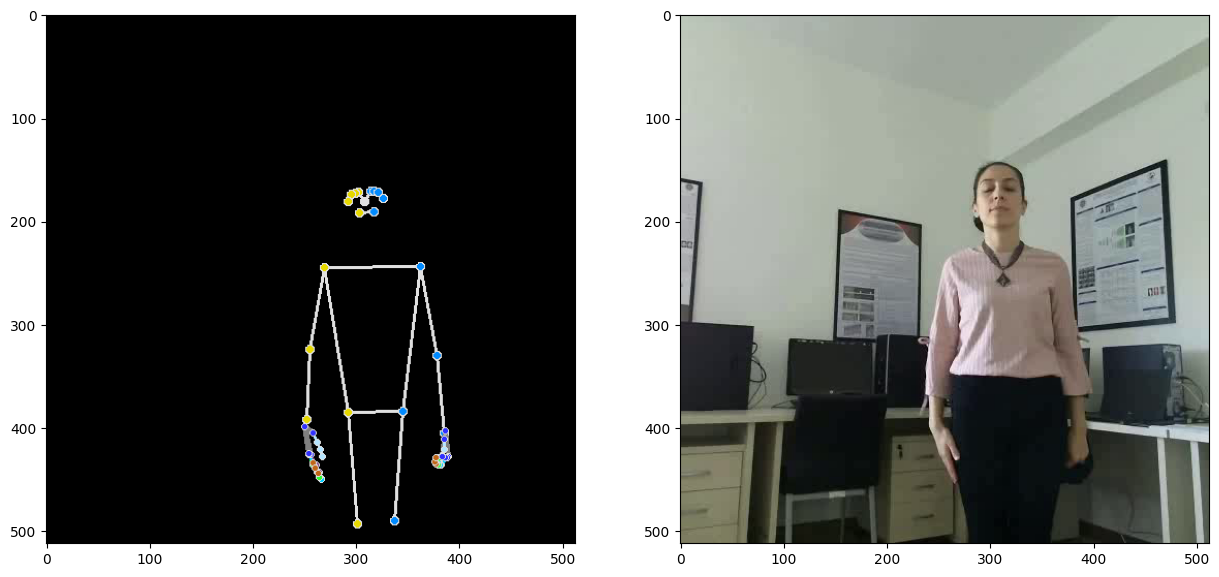

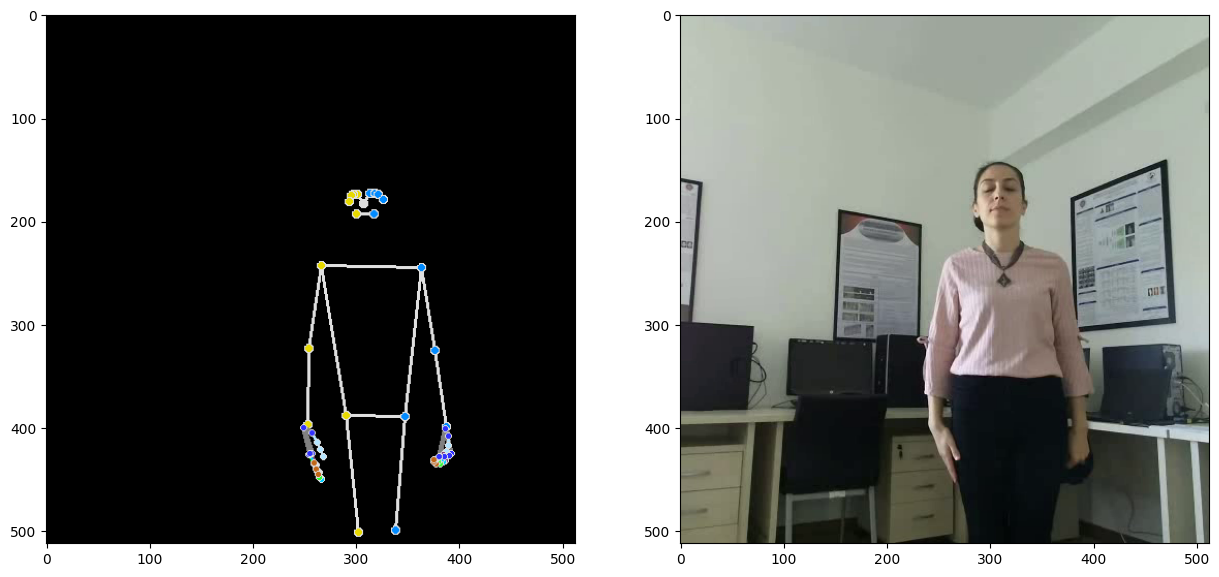

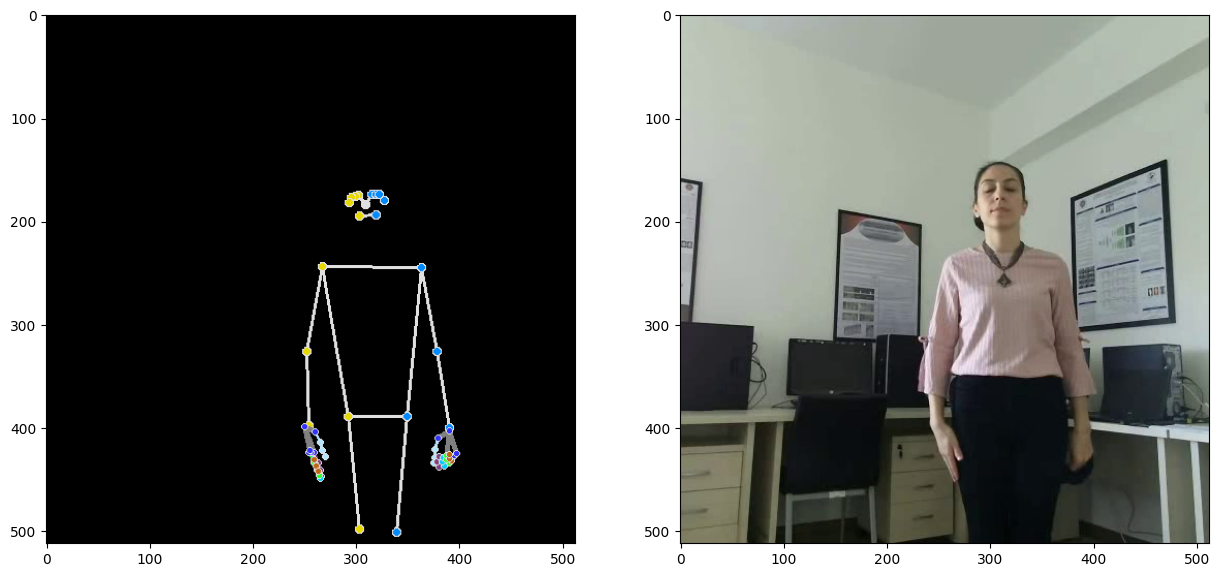

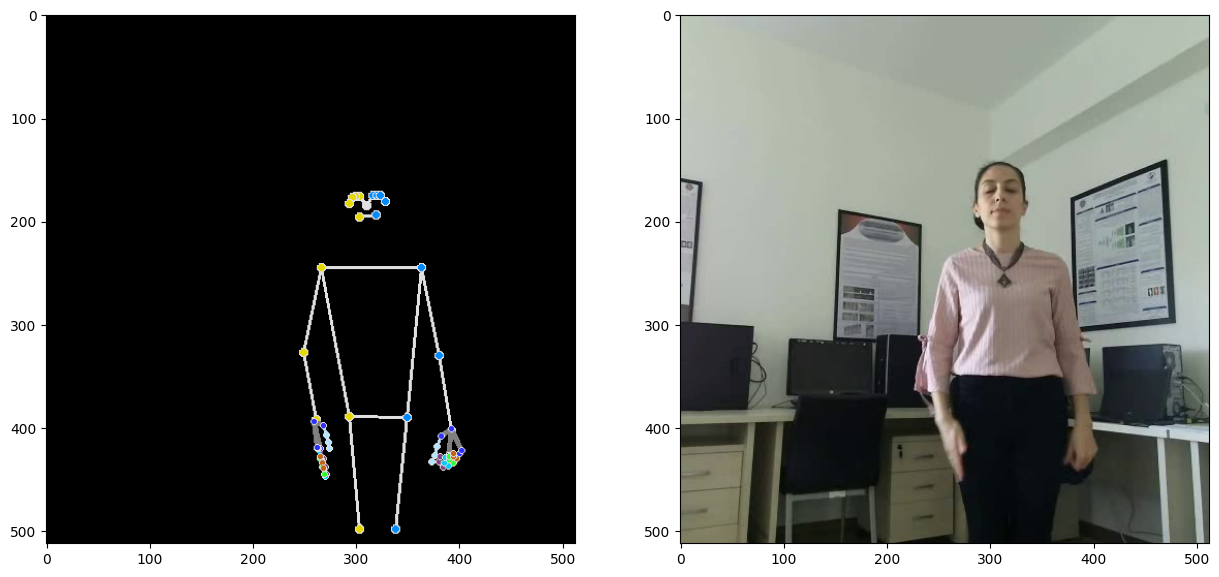

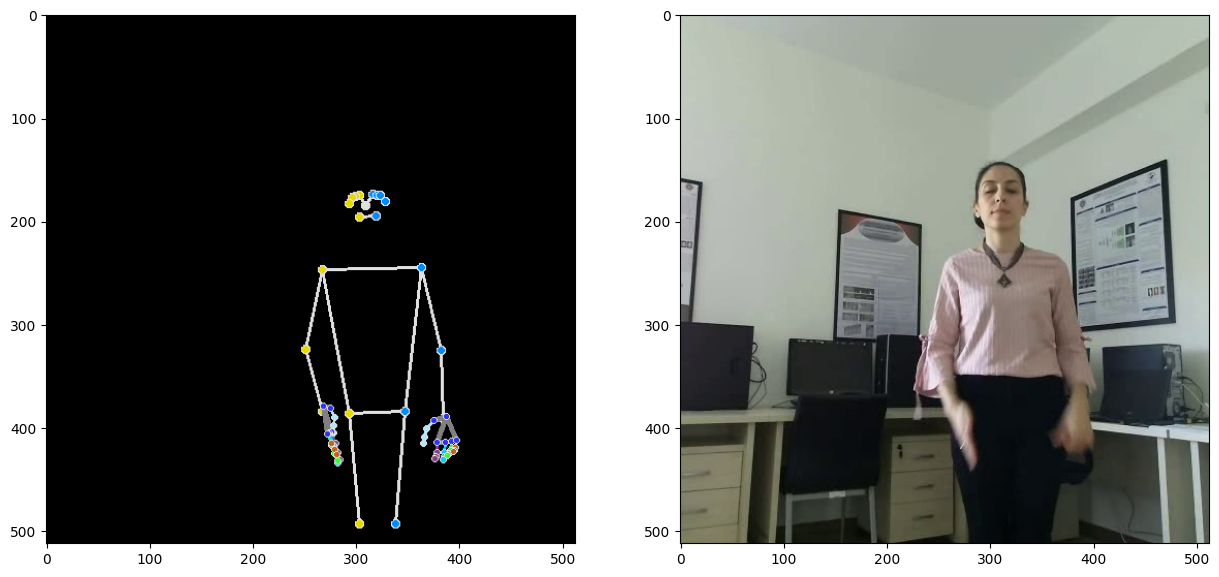

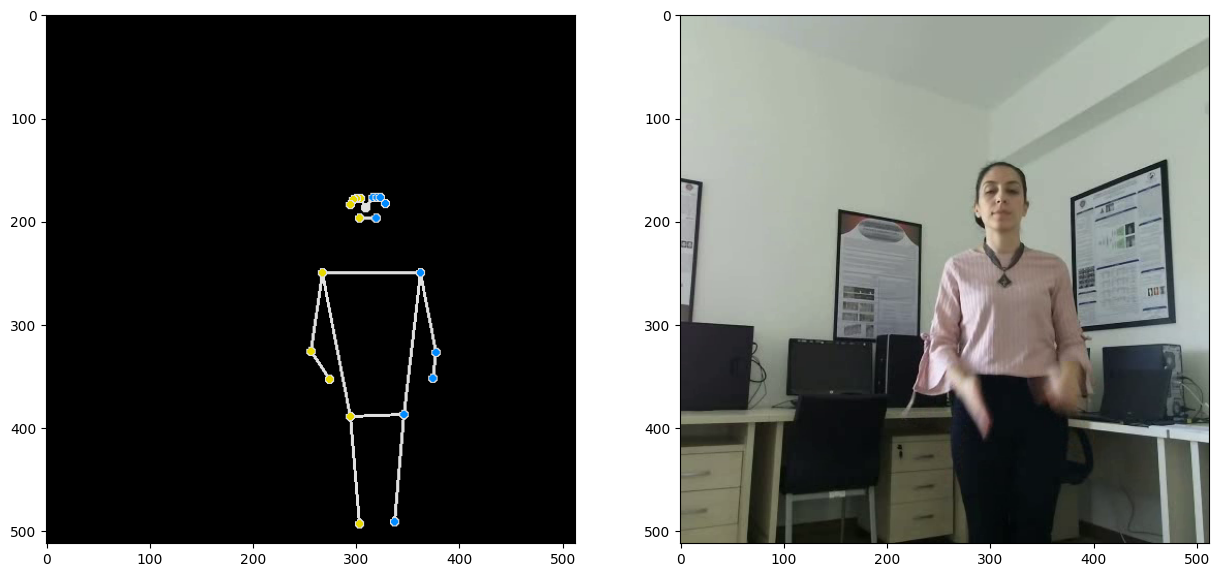

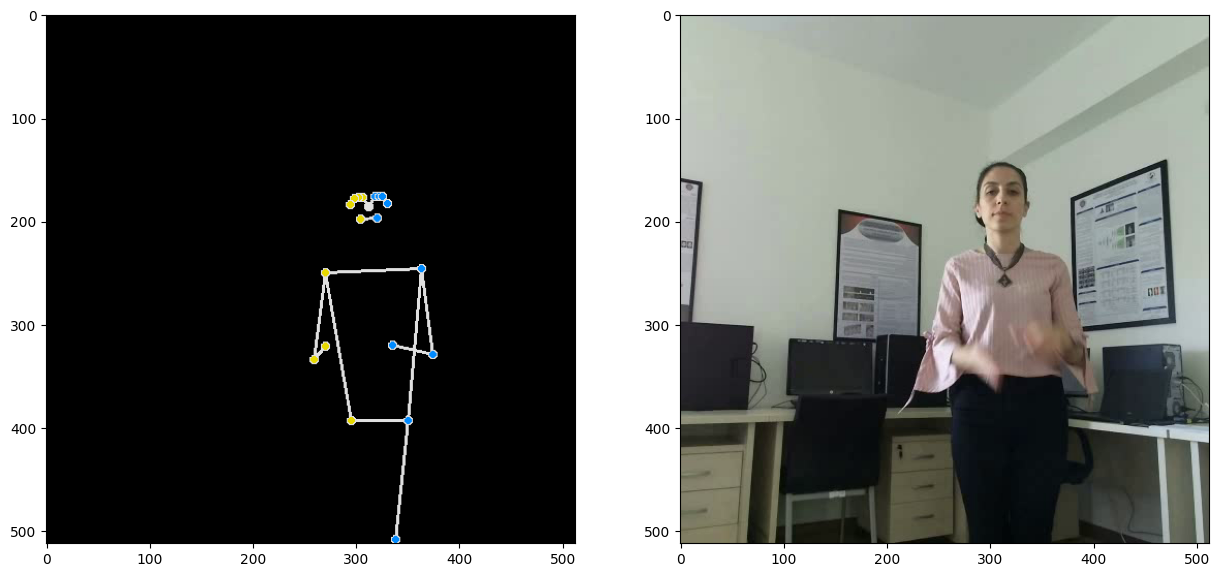

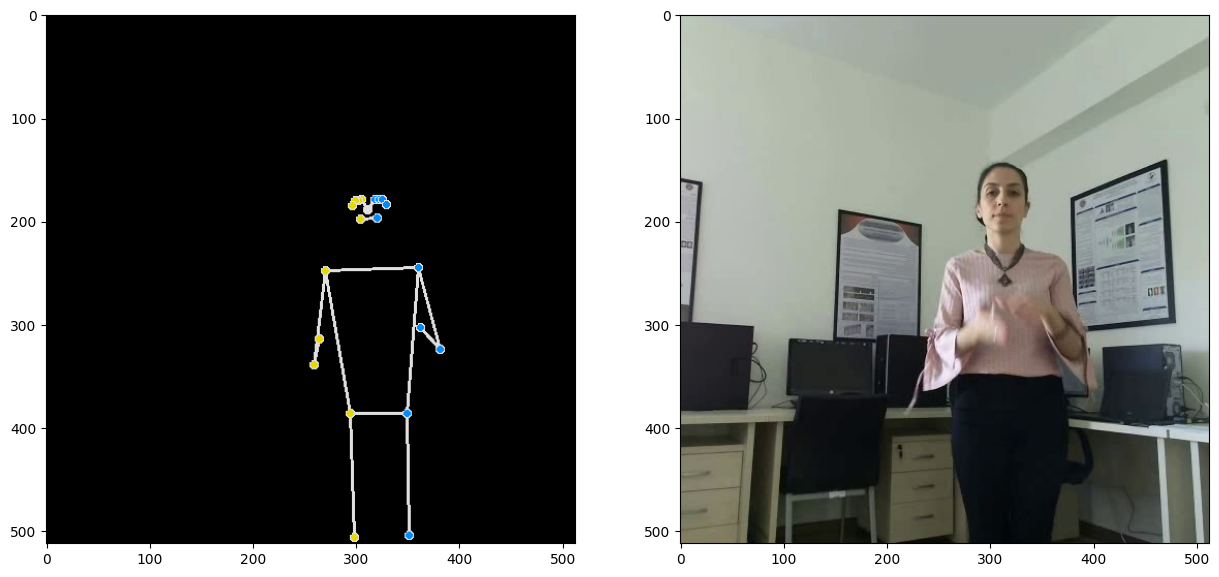

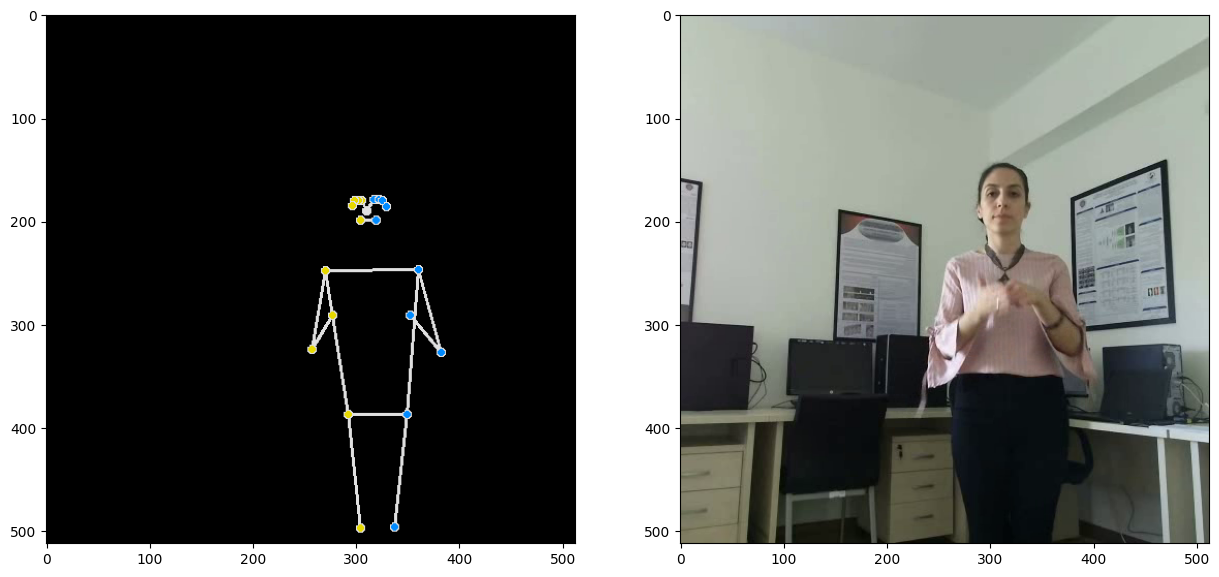

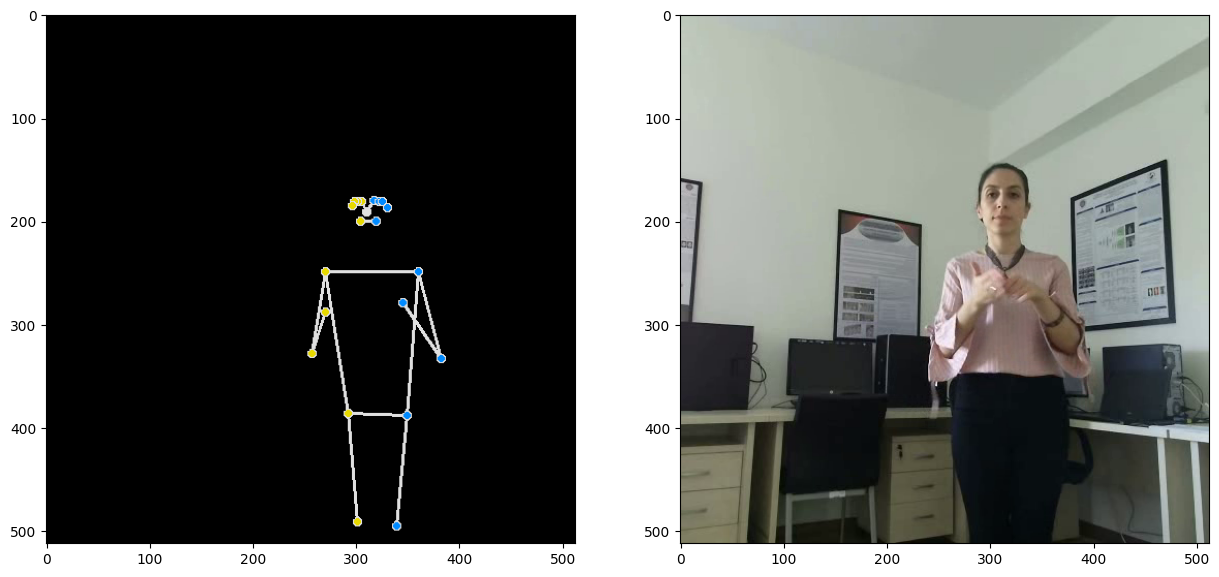

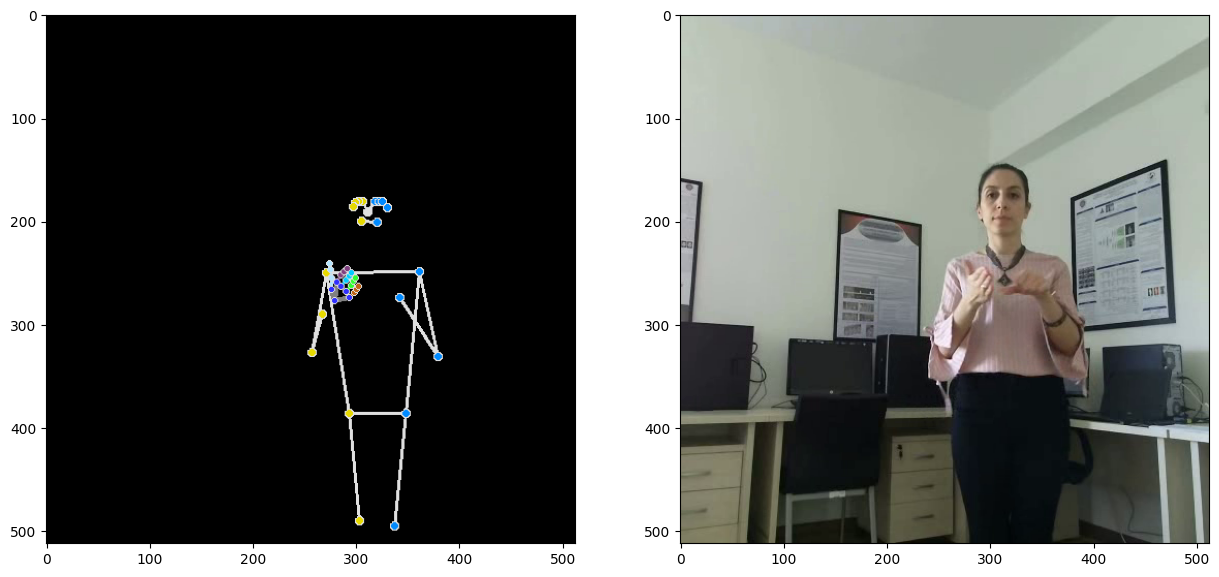

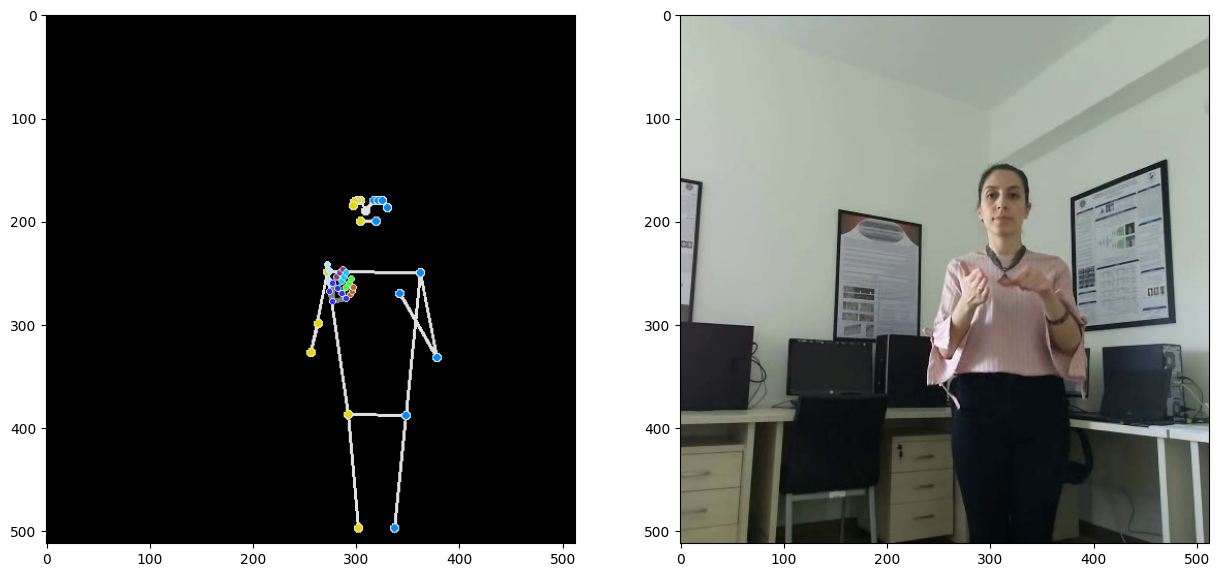

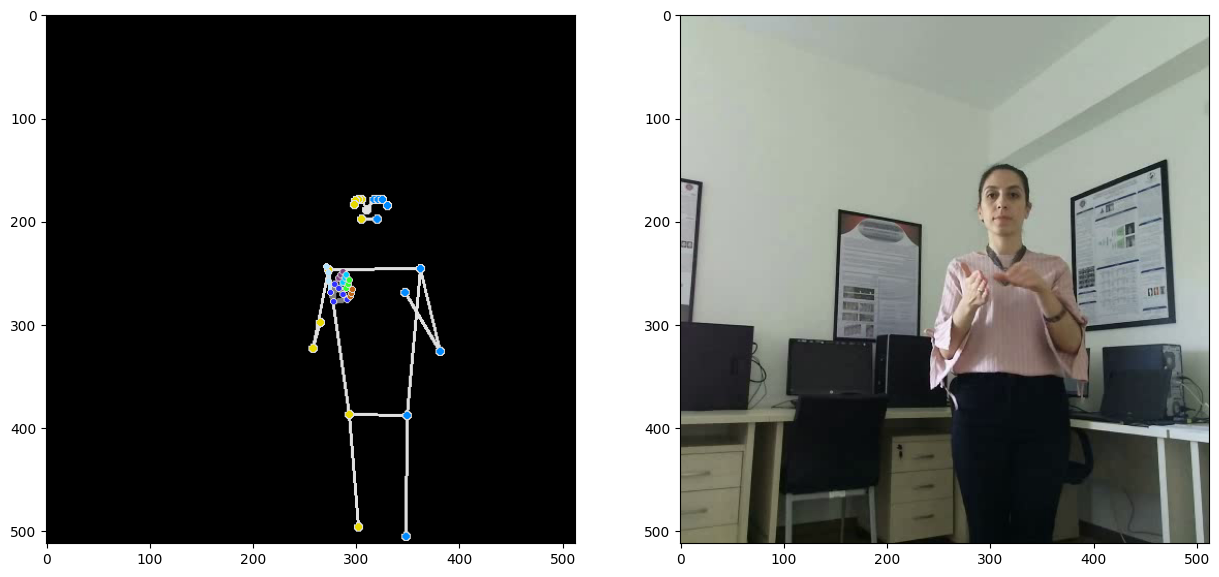

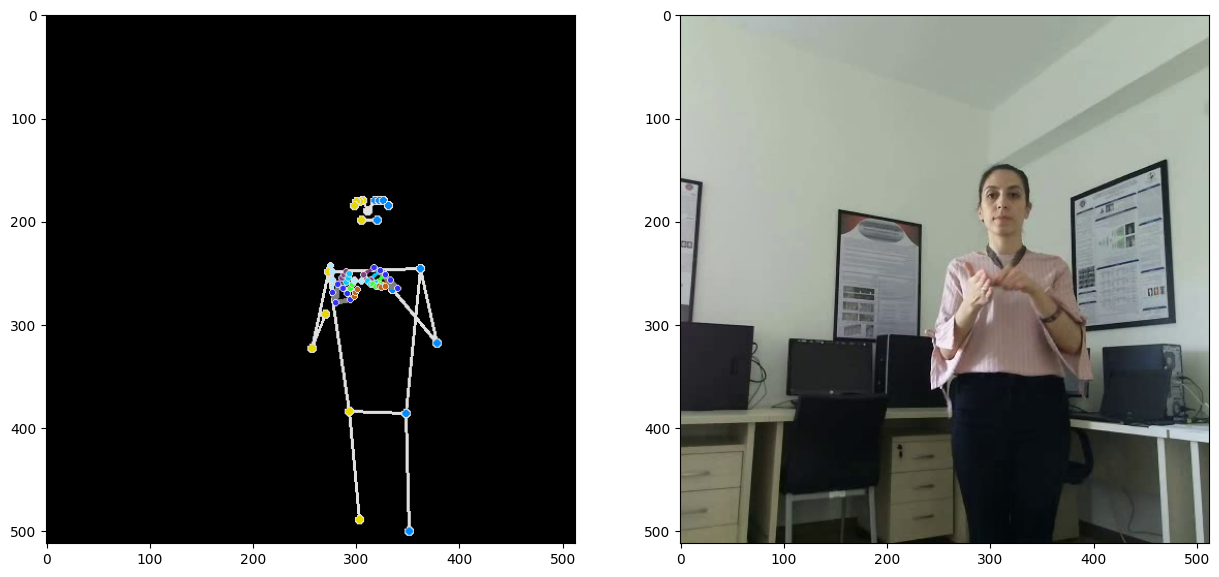

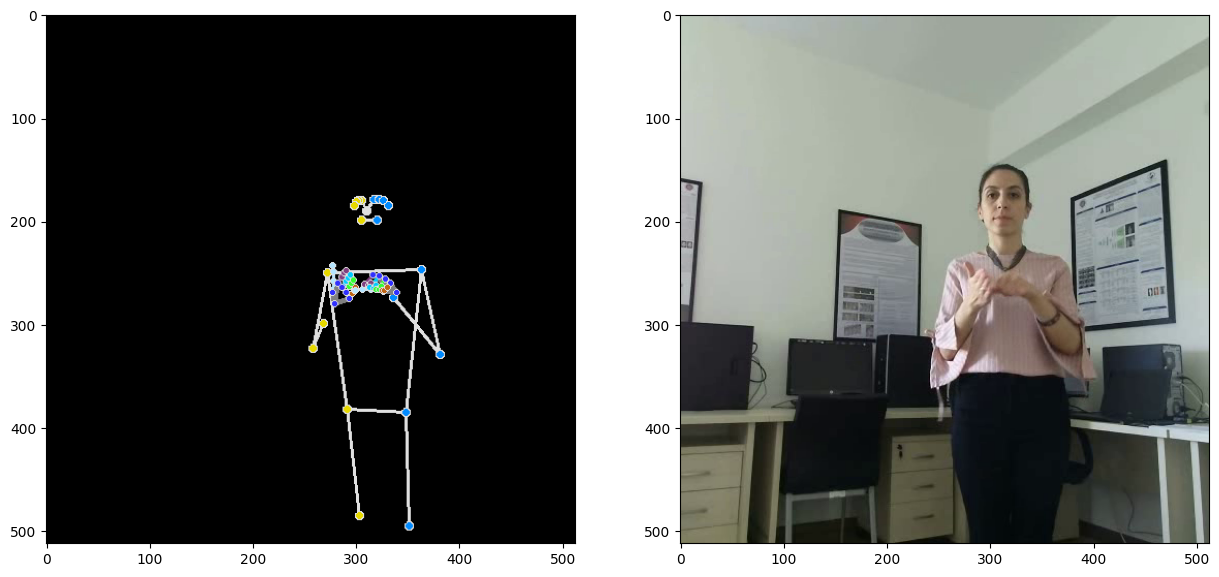

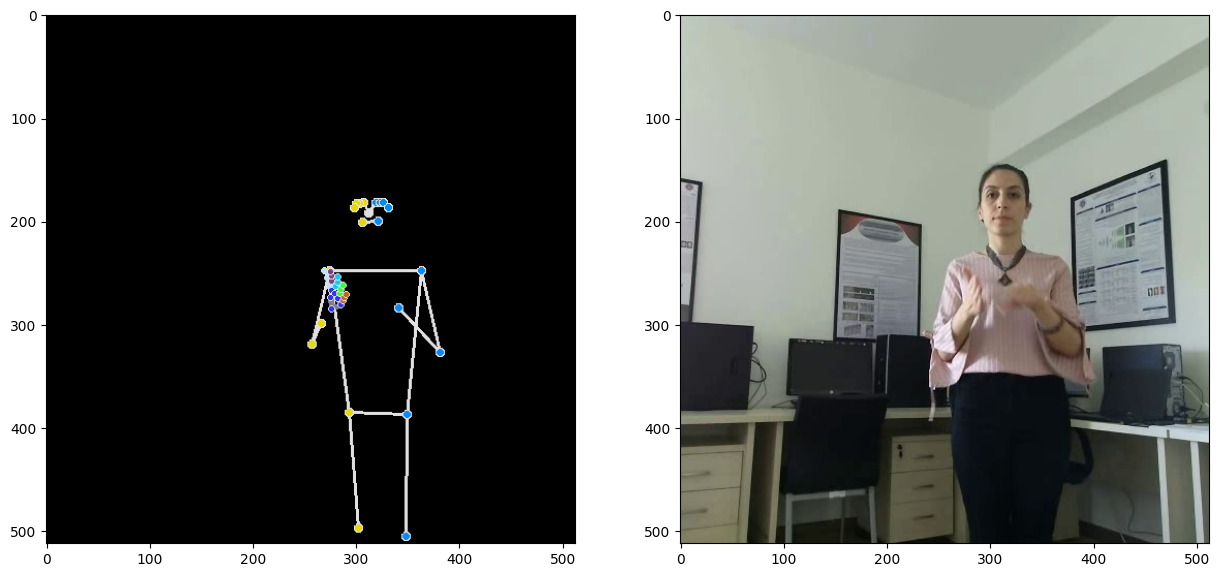

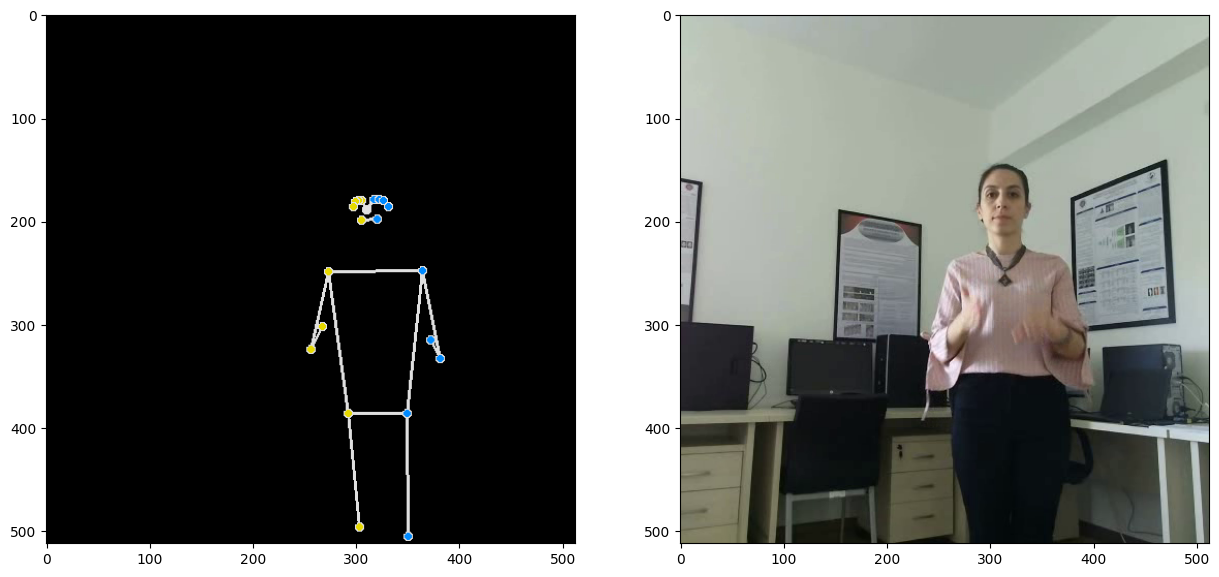

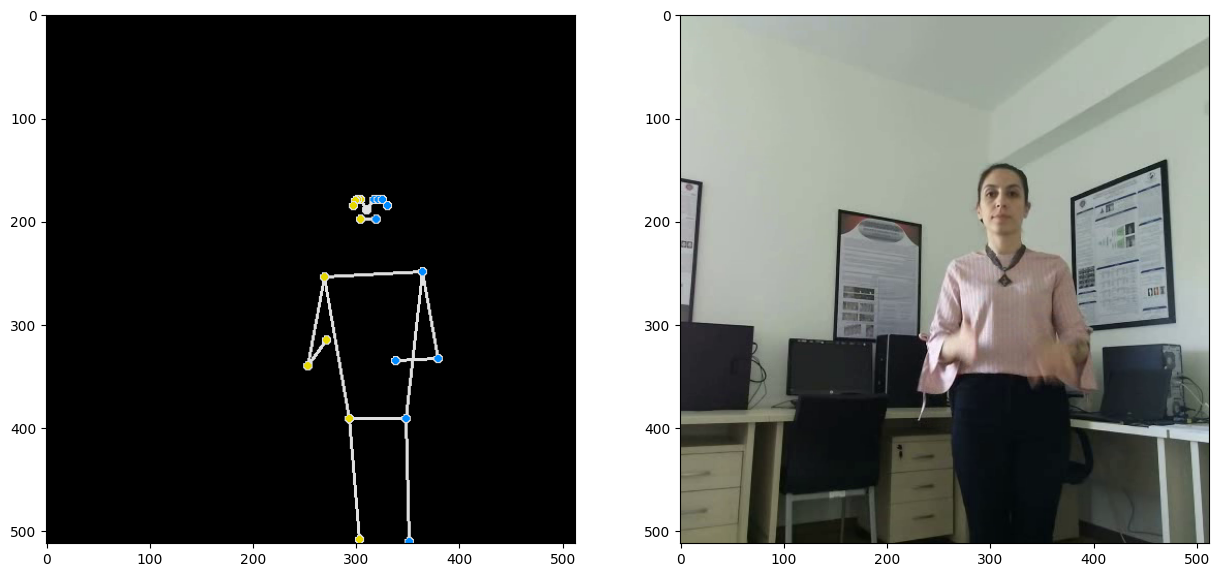

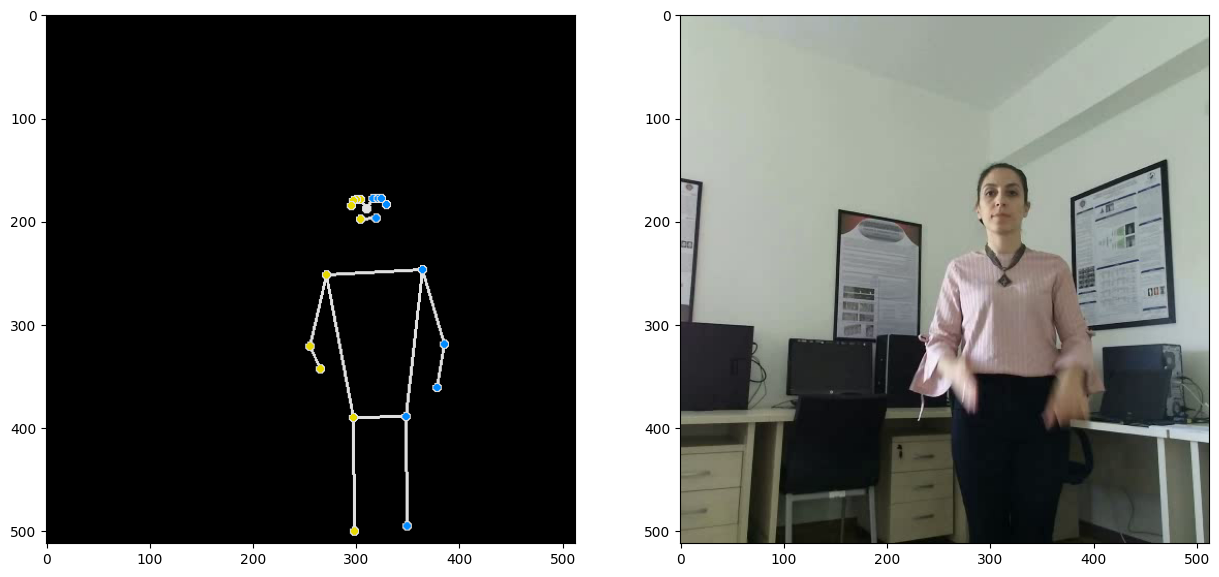

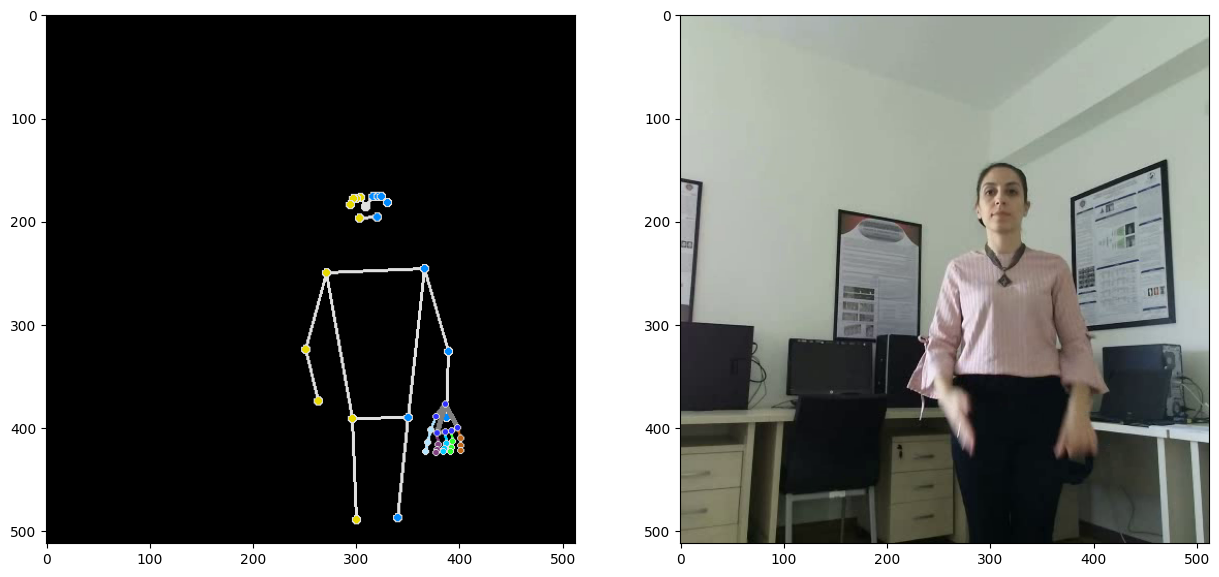

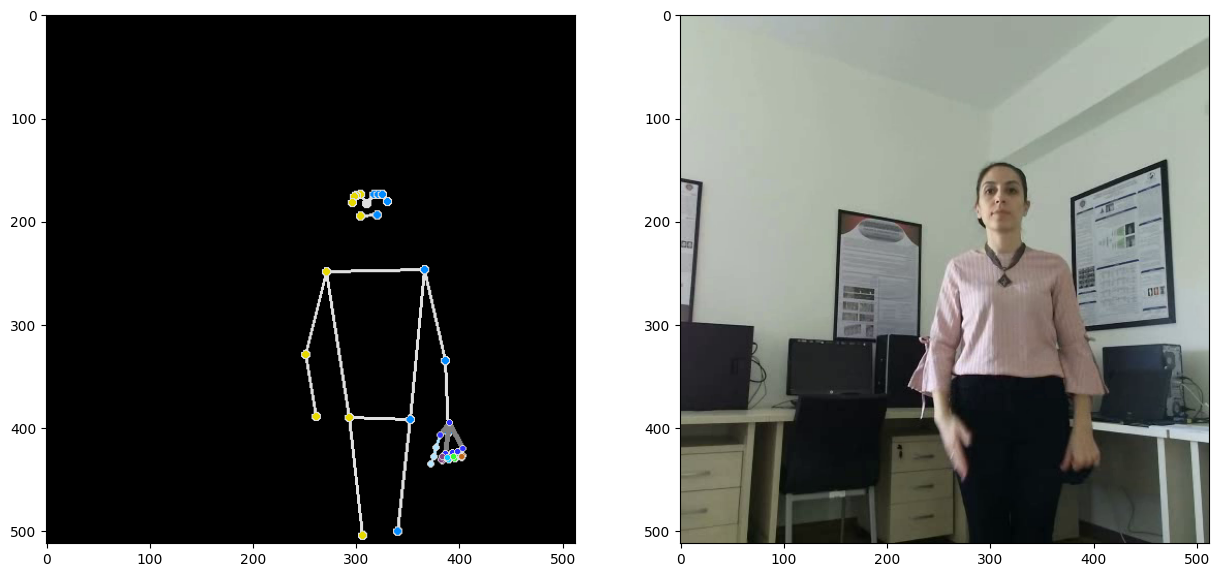

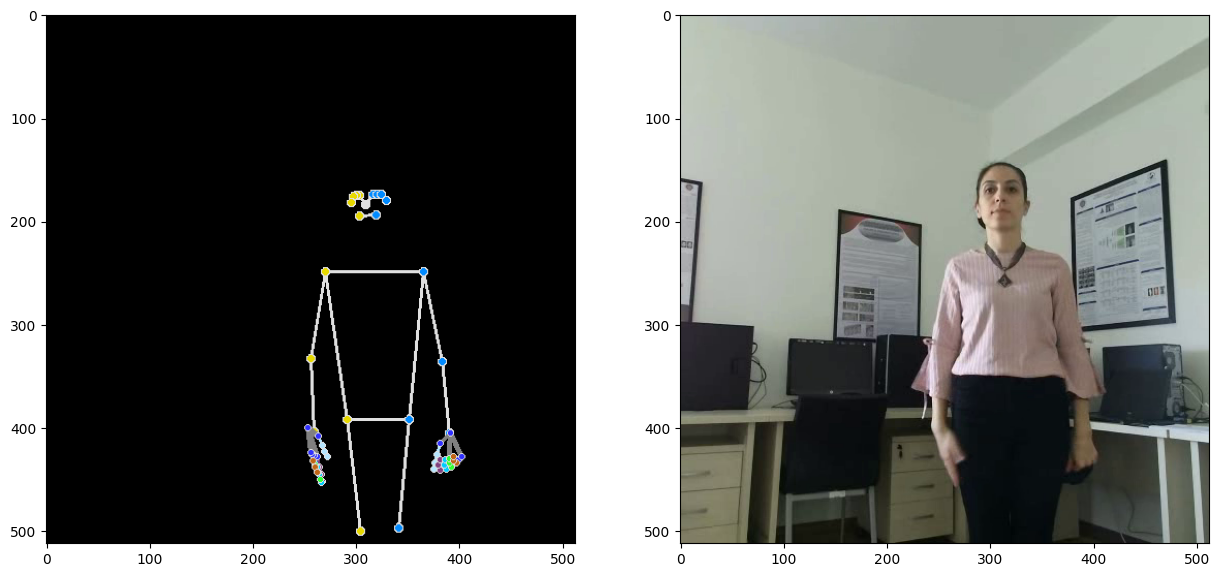

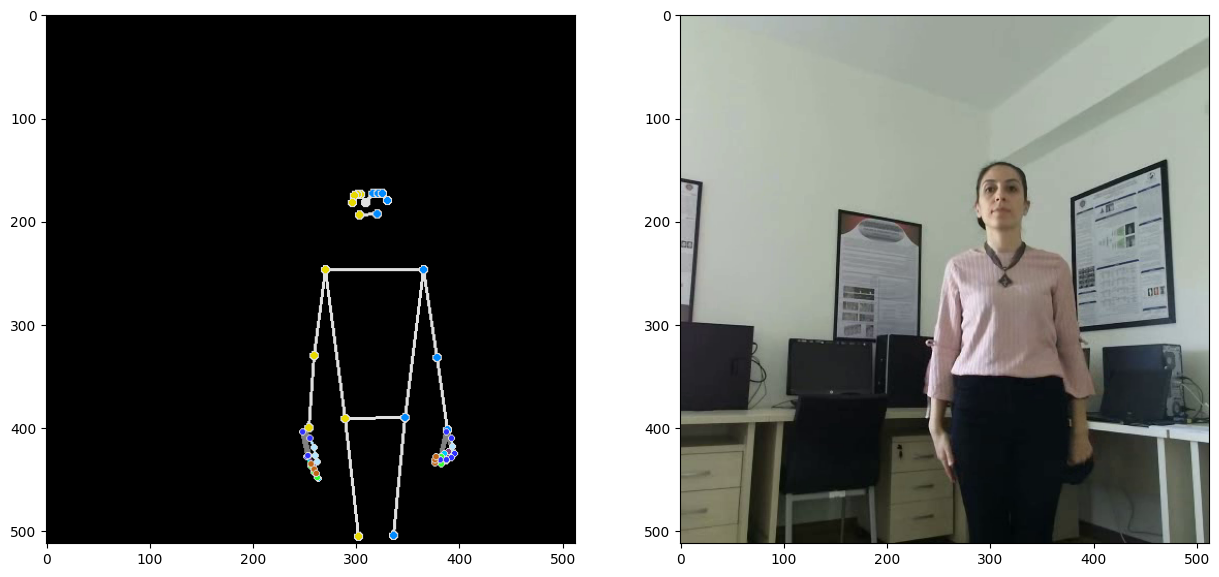

In [262]:
for i, (frame, annotation) in enumerate(zip(vid, results)):
    if i % 2 != 0:
        continue
    ann_frame = draw_poselandmarks_on_image(np.zeros_like (frame), annotation['pose'])
    ann_frame = draw_handlandmarks_on_image(ann_frame, annotation['hands'])
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(ann_frame)
    plt.subplot(1, 2, 2)
    plt.imshow(frame)
    plt.show()

In [263]:
def convert_video_ds_to_skeleton(dir_path='data/autsl/val/'):
    ans = []
    pool = Pool()

    def convert_video_to_skeleton(video_path):
        vid = read_video(video_path)

        if len(vid) == 0:
            print(video_path)
            return (video_path, None)

        return video_path, detect_skeleton_points(vid)

    file_path_gen = (os.path.join(dir_path, file)
                     for file in os.listdir(dir_path))
    for sample in tqdm(pool.imap(convert_video_to_skeleton, file_path_gen),
                       total=len(os.listdir(dir_path))):
        ans.append(sample)
        collect()

    pool.close()
    pool.join()

    return ans

In [ ]:
train_ds = convert_video_ds_to_skeleton('data/autsl/train/')

In [ ]:
collect()

In [ ]:
np.mean([len(b)for a,b in ans])

In [ ]:
len(train_ds)

In [ ]:
val_skeleton = {k:v for k,v in train_ds if v is not None}

In [13]:
import pickle

In [14]:
with open('data/autsl_skeleton/train_skeleton.pickle', 'wb') as file:
    pickle.dump(val_skeleton, file)

In [14]:
del val_skeleton, val_ds

In [17]:
collect()

0